# Skincancer HAM-dataset med Pytorch

In [1]:
do_training = True

## Standardimporter

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import os

import numpy as np
import pandas as pd
#from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## Hantering av GPU och CPU:

In [3]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [4]:
device = get_default_device()

In [5]:
# print(device)

### De båda nedanstående blocken används för att enkelt flytta till GPU: 

In [6]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [7]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

## Hjälpfunktioner för att spara och ladda:

In [8]:
# Anropas när följande variabler finns tillgängliga:
# epochs, batchsz-{train, val}, learning_rate
# Dessa krävs för funktionen "create_filename".

def create_filename(filename):
    global file_name
    file_name = filename + "_e" + str(epochs) + "_bsztr" + str(batchsz_train) + \
            "_bszval" + str(batchsz_val) + "_lr" + str(f'{learning_rate:.0e}')
    return file_name

In [9]:
# https://pytorch.org/docs/master/notes/serialization.html

def save_trained_model(modelname):
    model_folder = "trained_models"
    model_file_suffix = ".pt"
    create_filename(modelname) # spottar ur sig ett filnamn i variabeln "file_name"
    
    full_model_filename = model_folder + "/" + file_name + model_file_suffix
    
    torch.save(model.state_dict(), full_model_filename)

In [10]:
def load_trained_model(modelname):
    model_folder = "trained_models"
    model_file_suffix = ".pt"
    create_filename(modelname) # spottar ur sig ett filnamn i variabeln "file_name"
    
    full_model_filename = model_folder + "/" + file_name + model_file_suffix
    
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(full_model_filename))
    else:
        model.load_state_dict(torch.load(full_model_filename, map_location=torch.device('cpu')))

In [11]:
def save_training_log(logname, do_validation = True):
    log_folder = "logs"
    log_filename = create_filename(logname)
    log_file_suffix = ".csv"
    full_log_filename = log_folder + "/" + file_name + log_file_suffix
        
    global training_log
        
    # Speciell range nedan för att starta på epok 1 och ej 0:
    if do_validation == True:
        training_log = pd.DataFrame(data={"epoch": range(1, epochs + 1), \
                                              "train_acc": train_accuracy, \
                                              "train_loss": train_losses,  \
                                              "val_acc": val_accuracy, \
                                              "val_loss": val_losses})
    
        training_log.to_csv(full_log_filename, sep=',', index = False)
    else:
        training_log = pd.DataFrame(data={"epoch": range(1, epochs + 1), \
                                              "train_acc": train_accuracy, \
                                              "train_loss": train_losses})
    
        training_log.to_csv(full_log_filename, sep=',', index = False)
    
    return training_log

In [12]:
def load_training_log(logname):
    log_folder = "logs"
    log_filename = create_filename(logname)
    log_file_suffix = ".csv"
    full_log_filename = log_folder + "/" + file_name + log_file_suffix
    
    global training_log
    training_log = pd.read_csv(full_log_filename)
    return training_log

## Definiera de olika mängderna för träning, validering och test:

In [13]:
epochs = 100
learning_rate = 1e-4

img_w = 224
img_h = 224
img_dim = 3

batchsz_train = 2**2
batchsz_val = 2**6
batchsz_test = 2**6

train_num_workers = 4
test_val_num_workers = 4

basepath = "../../../ml/Datasets/skin-cancer-mnist-ham10000/images_per_label_splitted_sets/"

In [14]:
# Definiera vilken augmentation som ska göras:
train_data_transform = transforms.Compose([
        transforms.RandomResizedCrop(img_w),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

val_test_data_transform = transforms.Compose([
        transforms.RandomResizedCrop(img_w),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

In [15]:
# Definiera de tre dataseten:
skincancer_train_dataset = datasets.ImageFolder(root = basepath + 'train/',
                                           transform = train_data_transform)

skincancer_valid_dataset = datasets.ImageFolder(root = basepath + 'val/',
                                           transform = val_test_data_transform)

skincancer_test_dataset = datasets.ImageFolder(root = basepath + 'test/',
                                              transform = val_test_data_transform)

In [16]:
# Skapa loaders för de tre dataseten:
train_loader = torch.utils.data.DataLoader(skincancer_train_dataset,
                                             batch_size = batchsz_train, 
                                             shuffle = True,
                                             pin_memory = True,
                                             drop_last = True,
                                             num_workers = train_num_workers)

valid_loader = torch.utils.data.DataLoader(skincancer_valid_dataset,
                                             batch_size = batchsz_val, 
                                             shuffle = True,
                                             num_workers = test_val_num_workers)

test_loader = torch.utils.data.DataLoader(skincancer_test_dataset,
                                             batch_size = batchsz_test, 
                                             shuffle = False,
                                             num_workers = test_val_num_workers)

### Skapa en weighted loader som hanterar obalansen mellan klasserna:

In [17]:
train_targets = train_loader.dataset.targets
# print(len(train_targets))

In [18]:
from torch.utils.data import WeightedRandomSampler

In [19]:
# Test för att oversampla vissa klasser...
# https://discuss.pytorch.org/t/how-to-implement-oversampling-in-cifar-10/16964/6

train_targets = train_loader.dataset.targets
class_count = np.unique(train_targets, return_counts=True)[1]
#print("Antal bilder per klass = ", class_count, "\n")

# Testa att köra med 1 / sevenones för att se en obalanserad, vanlig, loader
# och med 1 / class_count för att se hur det balanserade resultatet blir:

# sevenones = np.ones(7)
# weight = 1 / sevenones
weight = 1. / class_count
samples_weight = weight[train_targets]
samples_weight = torch.from_numpy(samples_weight)

# Replacement = True ger dragning med återläggning, vilket vi ska ha, 
# annars kommer de mindre klasserna "ta slut" i dragningen:
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

In [20]:
# Skapa en ny dataloader baserad på 
# träningssetet som är viktad klassivs:

# "pin_memory=True" gör att man flyttar data till GPU:n medan 
# vi kör träningen, vilket påskyndar arbetet radikalt, ffa
# om vi har komplexa modeller.
train_loader_weighted = DataLoader(skincancer_train_dataset, 
                             batch_size = batchsz_train, 
                             sampler = sampler, # kan ej ha shuffle = True med sampler!
                             pin_memory=True,
                             drop_last=True,
                             num_workers = train_num_workers)

In [21]:
# Definiera antalet klasser:

number_of_classes = len(test_loader.dataset.classes)

### Flytta *_loader till rätt device

In [22]:
train_dl = DeviceDataLoader(train_loader, device)
train_dl_weighted = DeviceDataLoader(train_loader_weighted, device)
valid_dl = DeviceDataLoader(valid_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

### Visa skillnader mellan oviktad och viktad loader:

In [66]:
print("Antal bilder per klass = ", class_count, "\n")

# Visa hur den drar samples från klasserna för fyra batcher:
for batch_idx, (data, target) in enumerate(train_loader_weighted):
    print('Batch {}, classes {}, count {}'.format(
        batch_idx, *np.unique(target.numpy(), return_counts=True)))
    if batch_idx == 3:
        break

Antal bilder per klass =  [ 228  359  769   80  779 4693   99] 

Batch 0, classes [2 5 6], count [1 1 2]
Batch 1, classes [0 1 2 4], count [1 1 1 1]
Batch 2, classes [1 3 6], count [1 2 1]
Batch 3, classes [2 3 5], count [1 1 2]


In [67]:
print("Antal bilder per klass = ", class_count, "\n")

# Visa hur den drar samples från klasserna för fyra batcher:
for batch_idx, (data, target) in enumerate(train_loader):
    print('Batch {}, classes {}, count {}'.format(
        batch_idx, *np.unique(target.numpy(), return_counts=True)))
    if batch_idx == 3:
        break

Antal bilder per klass =  [ 228  359  769   80  779 4693   99] 

Batch 0, classes [2 4 5], count [1 1 2]
Batch 1, classes [2 5], count [1 3]
Batch 2, classes [1 2 5], count [2 1 1]
Batch 3, classes [2 5], count [3 1]


In [68]:
# len(target) # ger en vektor med batchsz i storlek.

# Kolla t.ex. hur många samples ur klass A som finns i sista batchen ovan:
# A = 0
# np.sum(target.numpy() == A)

In [69]:
# Visa dimensionerna för en bild-tensor (batchsize, number of channels, width, height):
# images.shape

## Definiera en modell:

In [23]:
# Nedanstående två rader måste göras oavsett träning eller ej:

model = models.densenet169(pretrained = True, progress = True)

In [24]:
# Printa modellen för att se de sista FC-lagren som behöver bytas ut: 
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [25]:
models_last_fc_infeatures = 1664
model_name = 'Densenet169'

In [26]:
create_filename(model_name)

'Densenet169_e100_bsztr4_bszval64_lr1e-04'

In [28]:
if do_training == True:
    
    # Vi måste ändra på det sista FC-lagret i modellen, som från början
    # innehållet 1000 st out-features. Vi behöver bara 7.

    for param in model.parameters():
        param.require_grad = False
    
    # Ersätt sista fc-lagret med rätt antal ut-klasser: 
    model.classifier = nn.Linear(in_features = models_last_fc_infeatures, out_features = number_of_classes, bias = True)
    
else:
    model.classifier = nn.Linear(in_features = models_last_fc_infeatures, out_features = number_of_classes, bias = True)
    load_trained_model(model_name)
    model.eval()

### Flytta modellen till GPU, om en sådan finns:

In [29]:
# Flytta modellen till rätt device:

to_device(model, device)

# Verifiera att modellen är på rätt device:
# True => modellen finns på GPU.

next(model.parameters()).is_cuda

True

In [30]:
trainableparameters = []
for param in model.parameters():
    # trainableparameters = param.numel()
    trainableparameters.append(param.numel())
    num_trainable_params = np.sum(trainableparameters)
    
print(f'Antalet träningsbara parametrar är {num_trainable_params:,} st.')

Antalet träningsbara parametrar är 12,496,135 st.


## Definiera loss-function och vilken metod för optimering som ska användas:

In [31]:
# Definiera loss-function och vilken optimerare som ska användas:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [32]:
# Decay LR by a factor of 0.1 every 3 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.1)

## Följande återställer modellens vikter mellan olika körningar

In [33]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)

## Overfit på en batch för att se att modellen är rimlig

In [34]:
if do_training == True:

    model.apply(weights_init)
    model.train()

    inputs, labels = next(iter(train_dl_weighted))
    inputs = inputs.to(device)
    labels = labels.to(device)

    criterion_check_onebatch = nn.CrossEntropyLoss()
    optimizer_check_onebatch = optim.Adam(model.parameters(), lr = learning_rate)

    model.train()
    for epoch in range(31):
        optimizer_check_onebatch.zero_grad()
        outputs = model(inputs)
        loss = criterion_check_onebatch(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer_check_onebatch.step()
        correct = torch.sum(preds == labels)
    
        if epoch%10 == 0:
            print(f'Epok {epoch:02}: ----- loss = {loss:4.4f} ----- accuracy = {correct}')
else:
    pass

# Träna och utvärdera modellen

In [35]:
def train_eval(epochs = 10, do_validation = True, training_dataloader = train_dl_weighted, validation_dataloader = valid_dl):

    # if ((do_training == False) and (do_validation == True)):
    #    print("Kan inte validera en modell som inte tränats.")
    # else:
    start_training_time = time.time()

    # Placeholders för att mäta modellen:
    global train_accuracy, train_losses, val_accuracy, val_losses
        
    train_accuracy = []
    train_losses = []
        
    val_accuracy = []
    val_losses = []

    for epoch in range(epochs):
        start_epoch_time = time.time()
        train_correct_pred_per_epoch = 0
        
        current_train_loss = 0.0
        current_train_corrects = 0
        
        # Träning ###########################################################
        # Sätt modellen i träningsläge:
        start_train_time = time.time()
        model.train()
        
        for inputs_train, labels_train in training_dataloader:
            train_predictions = model.forward(inputs_train)
            optimizer.zero_grad()
            
            train_loss = criterion(train_predictions, labels_train)
            train_loss.backward()
                
            optimizer.step()
                    
            #exp_lr_scheduler.step()
            #lr = exp_lr_scheduler.get_lr()
                
            # Nedan ger den mest troliga klassen:
            _, train_predicted = torch.max(train_predictions, 1)
    
            current_train_loss += train_loss.item() * batchsz_train
            current_train_corrects += torch.sum(train_predicted == labels_train.data)
        
        end_train_time = time.time()
        
        # Validering ########################################################
        # Sätt modellen i utvärderingsläge:
            
        if do_validation == True:
            start_eval_time = time.time()
            model.eval()
        
            current_val_loss = 0.0
            current_val_corrects = 0
        
            with torch.no_grad():
                
                inputs_val, labels_val = next(iter(validation_dataloader))
                val_predictions = model.forward(inputs_val)
                val_loss = criterion(val_predictions, labels_val)
                _, val_predicted = torch.max(val_predictions, 1)
                    
                current_val_loss += val_loss.item() * batchsz_val
                current_val_corrects += torch.sum(val_predicted == labels_val.data)
        
            end_eval_time = time.time()
        else:
            pass
            
        ######################################################################
        
        # Metrics ############################################################
        # Räkna ut acc och loss per epok:
        epoch_train_loss = np.float64(current_train_loss / num_train_images)
        epoch_train_acc = np.float64(current_train_corrects.double() / num_train_images)
        
        if do_validation == True:
            epoch_val_loss = np.float64(current_val_loss / batchsz_val)
            epoch_val_acc = np.float64(current_val_corrects.double() / batchsz_val)
        else:
            pass
                
        # Lagra accuracy och loss per epok i en lista för t.ex. plottning:
        train_losses.append(epoch_train_loss)
        train_accuracy.append(epoch_train_acc)
            
        if do_validation == True:
            val_losses.append(epoch_val_loss)
            val_accuracy.append(epoch_val_acc)
        else:
            pass
                
        # Räkna ut tiderna per epok:
        end_epoch_time = time.time()
        epoch_time = end_epoch_time - start_epoch_time
        
        # epoch startar på 0, därav "+1" nedan:
        if do_validation == True:
            print(f"Epok {epoch + 1:02}: {epoch_time:2.1f} sek, train-acc = {epoch_train_acc:4.3f}, val-acc = {epoch_val_acc:4.3f}, train-loss = {epoch_train_loss:4.4f}, val-loss = {epoch_val_loss:4.4f}")            
        else:
            print(f"Epok {epoch + 1:02}: {epoch_time:2.1f} sek, train-acc = {epoch_train_acc:4.3f}, train-loss = {epoch_train_loss:4.4f}")
    
    # Spara träningsdatat i en fil och i en pandas-df:
    save_training_log(model_name, do_validation)
    
    end_training_time = time.time()
    
    delta = end_training_time - start_training_time
    
    print(f'\nTraining took {delta:.2f} seconds.')

In [36]:
# Nollställer vikterna i modellen:
if do_training == True:
    model.apply(weights_init)
else:
    pass

# Nedan för att vi använder "droplast = True"...

# Train:
num_train_images = batchsz_train * np.floor_divide(len(train_loader.dataset), batchsz_train)
    
# Validation:
num_val_images = batchsz_val * np.floor_divide(len(valid_loader.dataset), batchsz_val)

In [37]:
# Här görs själva träningen, valideringen, sparande av modellen och träningsloggen.
# Alternativt så laddas en redan färdig modell/träningslogg.

# "epochs" definieras i början av filen!

if do_training == True:
    train_eval(epochs, do_validation=True, training_dataloader=train_dl_weighted, validation_dataloader=valid_dl)
    save_trained_model(model_name)
else:
    load_training_log(model_name)

FileNotFoundError: [Errno 2] File b'logs/Densenet169_e100_bsztr4_bszval64_lr1e-04.csv' does not exist: b'logs/Densenet169_e100_bsztr4_bszval64_lr1e-04.csv'

In [94]:
training_log.head()

,epoch,train_acc,train_loss,val_acc,val_loss
0,1,0.338806,1.675063,0.265625,3.8738


## Utvärdering av modellen:

### Grafer över accuracy och loss på train/validation:

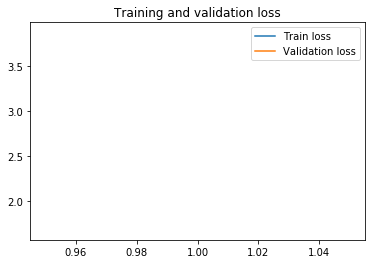

In [95]:
plt.plot(training_log['epoch'], training_log['train_loss'])
#plt.title("Loss on the training set over the epochs")
# plt.yticks(np.arange(0, 50, step = 5))
# plt.ylim(0,50)
#plt.show()

# Plotta accuracy över valideringsdatat:
plt.plot(training_log['epoch'], training_log['val_loss'])
plt.title("Training and validation loss")
#plt.yticks(np.arange(0, 1.1, step = 0.2))
#plt.ylim(0, max())
plt.legend(['Train loss', 'Validation loss'], loc = 'upper right')
plt.show()


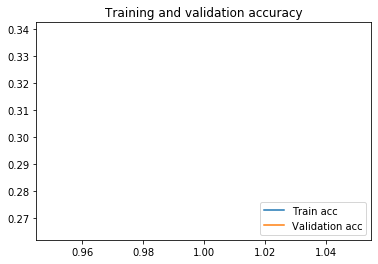

In [96]:
plt.plot(training_log['epoch'], training_log['train_acc'])
#plt.title("Loss on the training set over the epochs")
# plt.yticks(np.arange(0, 50, step = 5))
# plt.ylim(0,50)
#plt.show()

# Plotta accuracy över valideringsdatat:
plt.plot(training_log['epoch'], training_log['val_acc'])
plt.title("Training and validation accuracy")
#plt.yticks(np.arange(0, 1.1, step = 0.2))
#plt.ylim(0, max())
plt.legend(['Train acc', 'Validation acc'], loc = 'lower right')
plt.show()

In [38]:
max_train_acc = 100*max(training_log['train_acc'])

In [39]:
print(f'Max tränings-accuracy = {max_train_acc:.2f} %.')

Max tränings-accuracy = 88.81 %.


### Utvärdera modellen på validation- och test-set:

In [40]:
def evaluate_model(num_eval_images, data_loader, model):

    model.eval()

    start_eval_test_time = time.time()
    
    # Nedan för att vi inte ska uppdatera 
    # modellens vikter:

    with torch.no_grad():
        correct = 0
        # Antal iterationer = num_test_images / batchsz_test = x st.
    
        for X_test, y_test in data_loader:
            y_pred_test = model.forward(X_test)
            predicted = torch.max(input = y_pred_test, dim = 1)[1]
            correct += (predicted == y_test).sum()
    
        end_eval_test_time = time.time()
    
        eval_test_time = end_eval_test_time - start_eval_test_time

    print(f'Test accuracy: {correct.item()}/{num_eval_images} = {correct.item()*100/(num_eval_images):5.2f} %')
    print(f"\nEvaluation took {eval_test_time:.2f} seconds.")

In [41]:
num_test_images = len(test_loader.dataset)

evaluate_model(num_test_images, test_dl, model)

Test accuracy: 1442/2010 = 71.74 %

Evaluation took 8.27 seconds.


In [42]:
num_valid_images = len(valid_loader.dataset)

evaluate_model(num_valid_images, valid_dl, model)

Test accuracy: 749/998 = 75.05 %

Evaluation took 4.61 seconds.


### Confusion matrix

In [44]:
def pytorch_confusion_matrix(num_classes, model, dataloader):
    
    confusion_matrix = torch.zeros(num_classes, num_classes)
    
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataloader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            
            predictions = model.forward(inputs)
            _, preds = torch.max(predictions, 1)
            
            for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    
    return confusion_matrix

In [45]:
# Beräkningen på test-setet tar ca. 24 sek.
# på den stationära datorn med GPU med 4 workers, 
# och ca. 19 sek. med 8 workers.

start_cm_time = time.time()
cm_test = pytorch_confusion_matrix(number_of_classes, model, test_dl)

end_cm_time = time.time()

delta_cm_time = end_cm_time - start_cm_time

print(f'Beräkningen av CM tog {delta_cm_time:.2f}.')

Beräkningen av CM tog 8.59.


In [46]:
# Spara confusion matrix till en fil...

cm_file_suffice = ".pt"
cm_filename = "results/" + file_name + cm_file_suffice
torch.save(cm_test, cm_filename)

In [47]:
# Ladda CM från en fil:

cm_test = torch.load(cm_filename)

In [48]:
cm_test_np = cm_test.numpy()

In [49]:
np.set_printoptions(suppress=True)
print(cm_test_np)

array([[3.800e+01, 1.900e+01, 4.000e+00, 0.000e+00, 3.000e+00, 2.000e+00,
        1.000e+00],
       [6.000e+00, 7.700e+01, 5.000e+00, 4.000e+00, 4.000e+00, 0.000e+00,
        8.000e+00],
       [1.200e+01, 1.300e+01, 1.250e+02, 1.200e+01, 2.500e+01, 3.100e+01,
        3.000e+00],
       [0.000e+00, 4.000e+00, 1.000e+00, 1.700e+01, 0.000e+00, 2.000e+00,
        0.000e+00],
       [6.000e+00, 1.100e+01, 2.500e+01, 0.000e+00, 1.400e+02, 3.800e+01,
        3.000e+00],
       [9.000e+00, 3.300e+01, 4.900e+01, 3.600e+01, 1.640e+02, 1.025e+03,
        2.600e+01],
       [0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        2.400e+01]], dtype=float32)

### Precision och recall (precision & sensitivitet):

In [50]:
# Beräkna första radens summa:
sum_row_one = np.sum(cm_test_np[:,0])

# Då blir t.ex. precision för label 1:
precision_label_one = cm_test_np[0][0].item() / sum_row_one

In [51]:
print(f'Precision för label 1 = {precision_label_one:.3f}')

Precision för label 1 = 0.535


In [52]:
# Motsvarande blir recall för label 1:

sum_col_1 = np.sum(cm_test_np[0,:])
recall_label_one = cm_test_np[0][0] / sum_col_1

print(f'Recall för label 1 = {recall_label_one:.3f}')

Recall för label 1 = 0.567


In [53]:
# Få ut labels så här:
test_loader.dataset.classes[0]

'akiec'

In [54]:
# Skapa en sammanställning över precision/recall för alla sju klasser.

# Precision:

print("Precision för respektive klass:")
for i in range(number_of_classes):
    sum_row_i = np.sum(cm_test_np[:, i])
    recall_i = cm_test_np[i,i] / sum_row_i
    print(f'{test_loader.dataset.classes[i]:5}: {recall_i:.3f}')


# Recall:

print("\nRecall för respektive klass:")
for j in range(number_of_classes):
    sum_col_j = np.sum(cm_test_np[j, :])
    recall_j = cm_test_np[j,j] / sum_col_j
    print(f'{test_loader.dataset.classes[j]:5}: {recall_j:.3f}')

Precision för respektive klass:
akiec: 0.535
bcc  : 0.484
bkl  : 0.598
df   : 0.246
mel  : 0.415
nv   : 0.932
vasc : 0.369

Recall för respektive klass:
akiec: 0.567
bcc  : 0.740
bkl  : 0.566
df   : 0.708
mel  : 0.628
nv   : 0.764
vasc : 0.828


### Visualisera modellens förutsägelser

In [ ]:
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode = was_training)
                    return
        model.train(mode = was_training)

In [ ]:
visualize_model(model, 4)